<a href="https://colab.research.google.com/github/ayushm-agrawal/pytorch-experiments/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
import PIL
import time
import random

import torch
import torchvision
import torchvision.models as models
import torch.nn.functional as F

from torch import nn, optim
from torchvision import transforms
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader, Dataset
from torch.utils import data

from PIL import Image
from datetime import datetime, timedelta
from sklearn.preprocessing import normalize
from prettytable import PrettyTable

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load Numpy CIFAR 100 Dataset

In [0]:
images = np.load('./drive/My Drive/DeepLearning/CIFAR/cifar_images.npy')
labels = np.load('./drive/My Drive/DeepLearning/CIFAR/cifar_labels.npy')

print(len(images), len(labels), len(np.unique(labels)))

50000 50000 100


## Pick CIFAR-100 Subset


We will pick 20 random classes from the CIFAR-100 dataset and we'll pick 250 random images per class. 

NOTE: This is currently being used for both training and testing... Suggested solutions?

In [0]:
np.random.seed(2)
unique_classes = np.unique(labels)
subset_classes_idx = np.random.choice(unique_classes.shape[0], 20, replace=False)
subset_classes = unique_classes[subset_classes_idx]
print(subset_classes, len(subset_classes))

[83 30 56 24 16 23  2 27 28 13 99 92 76 14  0 21  3 29 61 79] 20


In [0]:
# shuffle the dataset
count_dict = dict.fromkeys(subset_classes, 0)
shuffled = list(zip(images, labels))
random.shuffle(shuffled)
n_images, n_labels = zip(*shuffled)

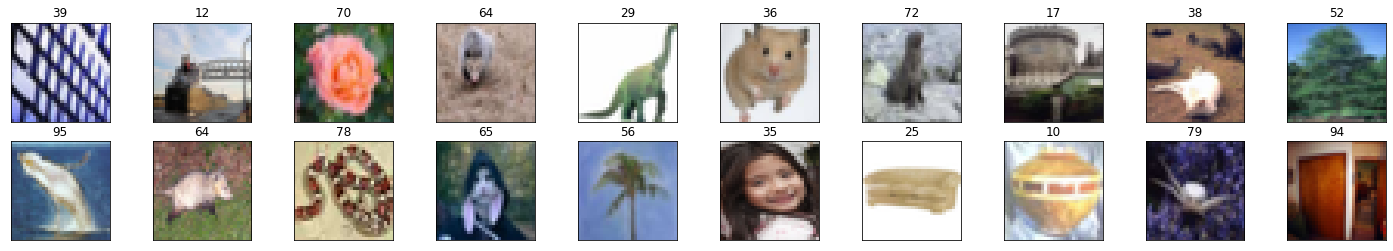

In [0]:
# plot the shuffled images for test
np.random.seed(3)
figure = plt.figure(figsize=(25,4))
for i in np.arange(20):
  axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(n_images[i].reshape((3,32,32)), (1,2,0))) # convert from tensor to image
  axis.set_title(n_labels[i])

In [0]:
print(len(n_images), len(n_labels))
print(count_dict)
print(len(count_dict))

50000 50000
{83: 0, 30: 0, 56: 0, 24: 0, 16: 0, 23: 0, 2: 0, 27: 0, 28: 0, 13: 0, 99: 0, 92: 0, 76: 0, 14: 0, 0: 0, 21: 0, 3: 0, 29: 0, 61: 0, 79: 0}
20


In [0]:
subset_imgs = []
subset_labels =[]

for i in range(len(n_images)):
  if n_labels[i] in count_dict:
    if count_dict[n_labels[i]] < 250:
      subset_imgs.append(n_images[i].reshape((3,32,32)))
      subset_labels.append(n_labels[i])
      count_dict[n_labels[i]] += 1

subset_imgs = np.asarray(subset_imgs)
subset_labels = np.asarray(subset_labels)

In [0]:
print(len(subset_imgs))
print(subset_imgs.shape)
print(type(subset_imgs))

5000
(5000, 3, 32, 32)
<class 'numpy.ndarray'>


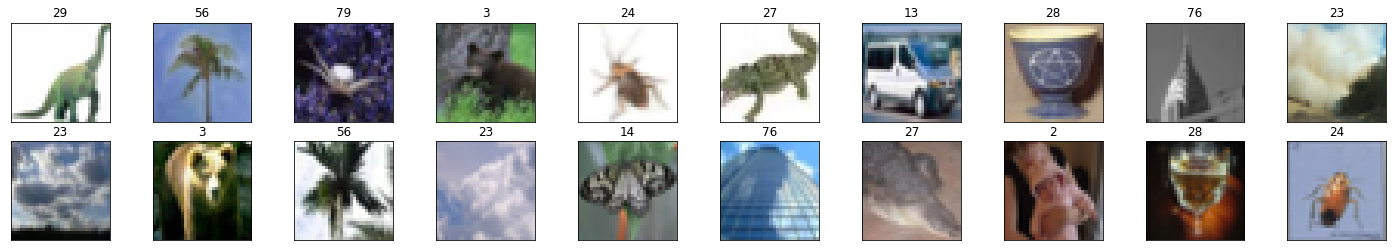

In [0]:
figure = plt.figure(figsize=(25,4))
for i in np.arange(20):
  axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(subset_imgs[i], (1,2,0))) # convert from tensor to image

  axis.set_title(subset_labels[i])

In [0]:
transform_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [0]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


def imshow(img, title=''):
    """Plot the image batch.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()


In [0]:
subset_imgs_new  = subset_imgs.astype('float64')
subset_imgs_new /= 255.0
print("Max: {}... \tMin: {}".format(subset_imgs_new.max(), subset_imgs_new.min()))
subset_normalized = subset_imgs_new
print(type(subset_normalized), type(subset_labels))
subset_normalized = torch.Tensor(subset_normalized)
subset_norm_labels = torch.Tensor(subset_labels)
my_dataset = CustomTensorDataset(tensors=(subset_normalized, subset_norm_labels), transform=transform_train)

Max: 1.0... 	Min: 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [0]:
train_loader = DataLoader(my_dataset, shuffle=True, batch_size=32, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of iterations required to get through training data:  157


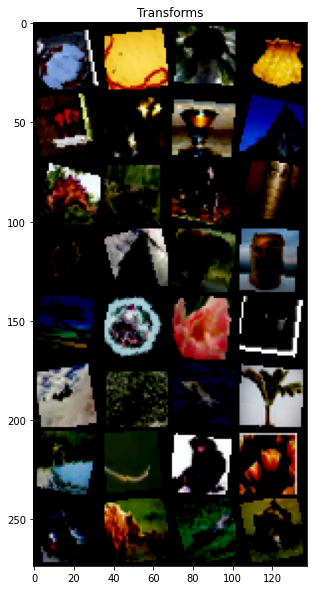

In [0]:
print('Number of iterations required to get through training data: ', len(train_loader))
for i, data in enumerate(train_loader):
    x, y = data  
    imshow(torchvision.utils.make_grid(x, 4), title='Transforms')
    break

## Data Loaders

In [0]:
def get_dataloaders(batch_size=32, shuffle=True, num_workers=0, dataset="CIFAR10"):

    # Create Transforms
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_valid = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    if(dataset == 'CIFAR100'):
      root_folder = './data/cifar100'
      # Get Training Data
      train_data = CIFAR100(root= root_folder, train=True, download=True, 
                              transform=transform_train)
      # Get Testing Data
      valid_data = CIFAR100(root=root_folder, train=False, download=True,
                            transform=transform_valid)
    else:
      root_folder = './data/cifar10'
      # Get Training Data
      train_data = CIFAR10(root=root_folder, train=True, download=True, 
                              transform=transform_train)
      # Get Testing Data
      valid_data = CIFAR10(root=root_folder, train=False, download=True,
                            transform=transform_valid)
    #class to idx mapping
    classes = train_data.class_to_idx


    # Create Dataloaders
    train_loader = DataLoader(train_data, 
                                          shuffle=shuffle, 
                                          batch_size=batch_size,
                                          num_workers=num_workers)
    
    valid_loader = DataLoader(valid_data, 
                                      batch_size=batch_size, 
                                      shuffle=False, 
                                      num_workers=num_workers)

    print('Number of iterations required to get through training data: ', len(train_loader))
    print('Number of iterations required to get through validation data: ', len(valid_loader))
    loaders = {"train": train_loader, "valid": valid_loader}

    return loaders, classes

In [0]:
loaders10, cifar10_classes = get_dataloaders()
print("CIFAR 10 Classes: {}".format(cifar10_classes))

loaders100, cifar100_classes = get_dataloaders(dataset="CIFAR100")
print("CIFAR 100 Classes: {}".format(cifar100_classes))

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified
Number of iterations required to get through training data:  1563
Number of iterations required to get through validation data:  313
CIFAR 10 Classes: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


Extracting ./data/cifar100/cifar-100-python.tar.gz to ./data/cifar100
Files already downloaded and verified
Number of iterations required to get through training data:  1563
Number of iterations required to get through validation data:  313
CIFAR 100 Classes: {'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree':

## Training Loop



In [0]:
def get_time_format(seconds):
    sec = timedelta(seconds=int(seconds))
    d = datetime(1,1,1) + sec
    if  d.day-1 == 1:
        return "%.2d:%.2d:%.2d:%.2d" % (d.day-1, d.hour, d.minute, d.second)
    return "%.2d:%.2d:%.2d" % (d.hour, d.minute, d.second)

def calculate_time( start_time ):
    return get_time_format(time.time() - start_time)

def print_info(pretty_table, epoch, train_loss, valid_loss, train_acc, 
               valid_acc, epoch_duration, train_duration, validation_duration, 
               valid_loss_info, model_saved):
  
    pretty_table.add_row([epoch, train_loss, valid_loss, train_acc, valid_acc, 
                          epoch_duration, train_duration, validation_duration, 
                          valid_loss_info, model_saved])
    print(pretty_table, end="\r")

def training_loop(n_epochs, loaders, model, optimizer, criterion, save_path):
    """
    This function performs model training.
    params:
        - n_epochs:
            Number of epochs to train.
        - loaders:
            Dictionary consisting of data loaders for train and validation
        - model:
            Model object/instance which is used for training.
        - optimizer:
            Optimizer for training.
        - criterion:
            Loss function for training.
        - save_path:
            Path to the directory where the best model is saved.
    returns:
        - model:
            Trained Model object/instance.
    
    """
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    pretty_table = PrettyTable([
        "Epoch No.",
        "Training Loss", 
        "Validation Loss", 
        "Training Accuracy", 
        "Validation Accuracy", 
        "Epoch Duration", 
        "Training Duration", 
        "Validation Duration", 
        "Validation loss decrease", 
        "Model Saved"
        ])

    # initialize time for training 
    total_training_duration = time.time()

    for epoch in range(1, n_epochs+1):

        # initialize time for each epoch
        epoch_duration = time.time()

        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # turn on train mode
        model.train()
        
        correct = 0.
        total = 0.
        train_duration = time.time()

        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            data, target = data.cuda(), target.cuda()
            
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            
            loss.backward()
            
            optimizer.step()
        
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            
            # record the average training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # accumulate correct predictions
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

            # accumulate total number of examples
            total += data.size(0)

        # compute training accuracy
        train_acc = correct / total
        
        train_duration = calculate_time(train_duration)
        

        #####################    
        #validate the model #
        #####################
        # turn on evaluation mode
        model.eval()
        correct = 0.
        total = 0.

        validation_duration = time.time()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]

            # record the average training loss
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            # accumulate correct predictions
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            # accumulate total number of examples
            total += data.size(0)
            
        # compute validation accuracy
        valid_acc = correct / total

        validation_duration = calculate_time(validation_duration)
        epoch_duration = calculate_time(epoch_duration)

        ## save the model if validation loss has decreased
        model_saved = False
        valid_loss_info = '-'

        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            model_saved = True
            valid_loss_info = "{:.6f} --> {:.6f}".format( valid_loss_min, valid_loss)

            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        pretty_table.add_row([epoch, train_loss, valid_loss, train_acc, valid_acc, epoch_duration, train_duration, validation_duration, valid_loss_info, model_saved])
        print("Training done : {}%".format(epoch/n_epochs * 100), end="\r")

    print(pretty_table)    
    print("Total training duration; {}".format(calculate_time(total_training_duration)))
    # # return trained model
    # return model

def new_training_loop(n_epochs, loaders, model, optimizer, criterion, save_path):
    """
    This function performs model training.
    params:
        - n_epochs:
            Number of epochs to train.
        - loaders:
            Dictionary consisting of data loaders for train and validation
        - model:
            Model object/instance which is used for training.
        - optimizer:
            Optimizer for training.
        - criterion:
            Loss function for training.
        - save_path:
            Path to the directory where the best model is saved.
    returns:
        - model:
            Trained Model object/instance.
    
    """
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    pretty_table = PrettyTable([
        "Epoch No.",
        "Training Loss", 
        "Training Accuracy", 
        "Epoch Duration", 
        "Training Duration"
        ])

    # initialize time for training 
    total_training_duration = time.time()

    for epoch in range(1, n_epochs+1):

        # initialize time for each epoch
        epoch_duration = time.time()

        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # turn on train mode
        model.train()
        
        correct = 0.
        total = 0.
        train_duration = time.time()

        for batch_idx, (data, target) in enumerate(loaders):
            # move to GPU
            data, target = data.cuda(), target.cuda()
            target = target.long()
            # print(data.shape)
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            
            optimizer.step()
        
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            
            # record the average training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # accumulate correct predictions
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

            # accumulate total number of examples
            total += data.size(0)

        # compute training accuracy
        train_acc = correct / total
        
        train_duration = calculate_time(train_duration)
        torch.save(model.state_dict(), save_path)
        pretty_table.add_row([epoch, train_loss, train_acc, epoch_duration, train_duration])
        print("Training done : {}%".format(epoch/n_epochs * 100), end="\r")  

    print(pretty_table)  
    print("Total training duration; {}".format(calculate_time(total_training_duration)))
    # # return trained model
    # return model

## Testing Loop

In [0]:
def test_model(test_model, num_classes, loaders):
  #test loss 
  test_loss = 0.0
  train_on_gpu = True
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))
  classes = np.arange(num_classes)

  test_model.eval()
  for data, labels in loaders100["valid"]:
    labels =labels.long()
    data, labels = data.cuda(), labels.cuda()

    output = test_model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(32):
      try:
        # print(i, labels.data[i])
        label = labels.data[i]
        correct_class[label] += correct[i].item()
        total_class[label] += 1
      except Exception as e:
        pass
    
  # avg test loss
  test_loss = test_loss/len(loaders100['valid'].dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  for i in range(num_classes):
    if total_class[i]>0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nFinal Test  Accuracy: %2d%% (%2d/%2d)' % (
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

## Model


In [0]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train Models

Here we use two different models...

*   Net is the custom model that was picked up from somewhere in Google. Can delete this if not required
*   Wide Resnet 50 is the PyTorch model that we loaded for some reason. 

<font color="orange">**We loaded wide resnet because it was on one of the cifar-100 benchmarks.**</font>

THOUGHTS HERE:

Refer to the GitHub Issue....
https://github.com/atharva-tendle/dlcti/issues/20



#### CIFAR SUBSET | CUSTOM MODEL | NUMPY LOADER

In [0]:
model = Net(num_classes=100)

model.cuda()

n_epochs = 100

criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

save_path = './drive/My Drive/cifar_subset_20.pt'

new_training_loop(n_epochs, train_loader, model, optimizer, criterion, save_path)

+-----------+---------------------------------+-------------------+--------------------+-------------------+
| Epoch No. |          Training Loss          | Training Accuracy |   Epoch Duration   | Training Duration |
+-----------+---------------------------------+-------------------+--------------------+-------------------+
|     1     | tensor(3.0136, device='cuda:0') |       0.1056      | 1586357524.5730965 |      00:00:03     |
|     2     | tensor(2.4826, device='cuda:0') |       0.2144      | 1586357527.6748276 |      00:00:02     |
|     3     | tensor(2.3746, device='cuda:0') |       0.248       | 1586357530.4891021 |      00:00:02     |
|     4     | tensor(2.2888, device='cuda:0') |       0.273       | 1586357533.2266455 |      00:00:02     |
|     5     | tensor(2.2196, device='cuda:0') |       0.2964      | 1586357536.132384  |      00:00:02     |
|     6     | tensor(2.1556, device='cuda:0') |       0.3078      | 1586357539.030884  |      00:00:02     |
|     7     | tenso

#### CIFAR 100 | CUSTOM MODEL | PYTORCH LOADER

In [0]:
model = Net(num_classes=100)

model.cuda()

n_epochs = 100

criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

save_path = './drive/My Drive/cifar_100.pt'

training_loop(n_epochs, loaders100, model, optimizer, criterion, save_path)

+-----------+---------------------------------+---------------------------------+-------------------+---------------------+----------------+-------------------+---------------------+--------------------------+-------------+
| Epoch No. |          Training Loss          |         Validation Loss         | Training Accuracy | Validation Accuracy | Epoch Duration | Training Duration | Validation Duration | Validation loss decrease | Model Saved |
+-----------+---------------------------------+---------------------------------+-------------------+---------------------+----------------+-------------------+---------------------+--------------------------+-------------+
|     1     | tensor(4.0475, device='cuda:0') | tensor(3.7363, device='cuda:0') |      0.07378      |        0.1268       |    00:00:27    |      00:00:25     |       00:00:02      |     inf --> 3.736314     |     True    |
|     2     | tensor(3.6465, device='cuda:0') | tensor(3.4658, device='cuda:0') |       0.1348      |   

#### CIFAR SUBSET | WIDE RESNET | NUMPY LOADER

In [0]:
new_resnet = models.wide_resnet50_2()
new_resnet.fc = nn.Linear(2048, 100)

new_resnet.cuda()
n_epochs = 100
# Load the Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_resnet.parameters())
# Train the Model and Save the Weights
save_path =  "./drive/My Drive/resnet_subset_20.pt"
new_training_loop(n_epochs, train_loader, new_resnet,
                  optimizer, criterion, save_path) 

#### CIFAR 100 | WIDE RESNET | PYTORCH LOADER

In [0]:
resnet_100 = models.wide_resnet50_2()
resnet_100.fc = nn.Linear(2048, 100)

resnet_100.cuda()
n_epochs = 100
# Load the Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_100.parameters())
# Train the Model and Save the Weights
save_path =  "./drive/My Drive/resnet_100.pt"
training_loop(n_epochs, loaders100, resnet_100,
                  optimizer, criterion, save_path) 

#### CIFAR SUBSET | RESNET 18 | NUMPY LOADER

In [0]:
new_resnet = models.resnet18()
new_resnet.fc = nn.Linear(512, 100)

new_resnet.cuda()
n_epochs = 100
# Load the Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_resnet.parameters())
# Train the Model and Save the Weights
save_path =  "./drive/My Drive/resnet18_subset_20.pt"
new_training_loop(n_epochs, train_loader, new_resnet,
                  optimizer, criterion, save_path) 

+-----------+---------------------------------+-------------------+--------------------+-------------------+
| Epoch No. |          Training Loss          | Training Accuracy |   Epoch Duration   | Training Duration |
+-----------+---------------------------------+-------------------+--------------------+-------------------+
|     1     | tensor(2.5864, device='cuda:0') |       0.2298      | 1586360616.7935662 |      00:00:06     |
|     2     | tensor(2.2021, device='cuda:0') |       0.3196      | 1586360623.1324809 |      00:00:06     |
|     3     | tensor(2.0728, device='cuda:0') |       0.3654      | 1586360629.5822957 |      00:00:06     |
|     4     | tensor(1.9242, device='cuda:0') |       0.4038      | 1586360635.967149  |      00:00:06     |
|     5     | tensor(1.8630, device='cuda:0') |       0.4258      | 1586360642.4030356 |      00:00:06     |
|     6     | tensor(1.7390, device='cuda:0') |       0.4638      | 1586360649.013242  |      00:00:06     |
|     7     | tenso

#### CIFAR 100 | RESNET 18| PYTORCH LOADER

In [0]:
resnet_100 = models.resnet18()
resnet_100.fc = nn.Linear(512, 100)

resnet_100.cuda()
n_epochs = 100
# Load the Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_100.parameters())
# Train the Model and Save the Weights
save_path =  "./drive/My Drive/resnet18_100.pt"
training_loop(n_epochs, loaders100, resnet_100,
                  optimizer, criterion, save_path) 

+-----------+---------------------------------+---------------------------------+-------------------+---------------------+----------------+-------------------+---------------------+--------------------------+-------------+
| Epoch No. |          Training Loss          |         Validation Loss         | Training Accuracy | Validation Accuracy | Epoch Duration | Training Duration | Validation Duration | Validation loss decrease | Model Saved |
+-----------+---------------------------------+---------------------------------+-------------------+---------------------+----------------+-------------------+---------------------+--------------------------+-------------+
|     1     | tensor(3.9174, device='cuda:0') | tensor(3.4929, device='cuda:0') |      0.10132      |        0.1556       |    00:00:39    |      00:00:36     |       00:00:02      |     inf --> 3.492939     |     True    |
|     2     | tensor(3.3803, device='cuda:0') | tensor(3.1022, device='cuda:0') |      0.18368      |   

## Test Models

We use two different datasets for testing here....

*   The subset that we created from CIFAR-100 **(train_loader)** . 5000 images and 250 images per class. There are 20 random classes that we picked.
*   The test set fetched from the PyTorch datasets **(loaders100["valid"])**. 10000 total images spread across 100 classes



#### CIFAR SUBSET | CUSTOM MODEL | NUMPY LOADER

In [0]:
model = Net(num_classes=100)
model.load_state_dict(torch.load('./cifar_subset_20.pt'))
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

test_model(model, 100, train_loader)

Test Loss: 27.393689

Test Accuracy of     0: 78% (78/100)
Test Accuracy of     1:  0% ( 0/100)
Test Accuracy of     2: 58% (58/100)
Test Accuracy of     3: 31% (31/100)
Test Accuracy of     4:  0% ( 0/100)
Test Accuracy of     5:  0% ( 0/100)
Test Accuracy of     6:  0% ( 0/100)
Test Accuracy of     7:  0% ( 0/100)
Test Accuracy of     8:  0% ( 0/100)
Test Accuracy of     9:  0% ( 0/100)
Test Accuracy of    10:  0% ( 0/100)
Test Accuracy of    11:  0% ( 0/100)
Test Accuracy of    12:  0% ( 0/100)
Test Accuracy of    13: 45% (45/100)
Test Accuracy of    14: 57% (57/100)
Test Accuracy of    15:  0% ( 0/100)
Test Accuracy of    16: 41% (41/100)
Test Accuracy of    17:  0% ( 0/100)
Test Accuracy of    18:  0% ( 0/100)
Test Accuracy of    19:  0% ( 0/100)
Test Accuracy of    20:  0% ( 0/100)
Test Accuracy of    21: 64% (64/100)
Test Accuracy of    22:  0% ( 0/100)
Test Accuracy of    23: 67% (67/100)
Test Accuracy of    24: 66% (66/100)
Test Accuracy of    25:  0% ( 0/100)
Test Accuracy of

#### CIFAR 100 | CUSTOM MODEL | PYTORCH LOADER

In [0]:
num_classes = 100
model = Net(num_classes)
model.load_state_dict(torch.load('./cifar_100.pt'))
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

test_model(model, num_classes, loaders100)

Test Loss: 2.567382

Test Accuracy of     0: 67% (67/100)
Test Accuracy of     1: 43% (43/100)
Test Accuracy of     2: 27% (27/100)
Test Accuracy of     3: 13% (13/100)
Test Accuracy of     4:  8% ( 8/100)
Test Accuracy of     5: 32% (32/100)
Test Accuracy of     6: 40% (40/100)
Test Accuracy of     7: 48% (48/100)
Test Accuracy of     8: 36% (36/100)
Test Accuracy of     9: 44% (44/100)
Test Accuracy of    10:  9% ( 9/100)
Test Accuracy of    11: 24% (24/100)
Test Accuracy of    12: 31% (31/100)
Test Accuracy of    13: 18% (18/100)
Test Accuracy of    14: 20% (20/100)
Test Accuracy of    15: 14% (14/100)
Test Accuracy of    16: 43% (43/100)
Test Accuracy of    17: 59% (59/100)
Test Accuracy of    18: 34% (34/100)
Test Accuracy of    19: 30% (30/100)
Test Accuracy of    20: 60% (60/100)
Test Accuracy of    21: 55% (55/100)
Test Accuracy of    22: 24% (24/100)
Test Accuracy of    23: 66% (66/100)
Test Accuracy of    24: 61% (61/100)
Test Accuracy of    25: 16% (16/100)
Test Accuracy of 

#### CIFAR SUBSET | WIDE RESNET | NUMPY LOADER

In [0]:
num_classes = 100
model = models.wide_resnet50_2()
model.fc = nn.Linear(2048, 100)
model.load_state_dict(torch.load('./resnet_subset_20.pt'))
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

test_model(model, num_classes, train_loader)

Test Loss: 33.787555

Test Accuracy of     0: 57% (57/100)
Test Accuracy of     1:  0% ( 0/100)
Test Accuracy of     2: 56% (56/100)
Test Accuracy of     3: 48% (48/100)
Test Accuracy of     4:  0% ( 0/100)
Test Accuracy of     5:  0% ( 0/100)
Test Accuracy of     6:  0% ( 0/100)
Test Accuracy of     7:  0% ( 0/100)
Test Accuracy of     8:  0% ( 0/100)
Test Accuracy of     9:  0% ( 0/100)
Test Accuracy of    10:  0% ( 0/100)
Test Accuracy of    11:  0% ( 0/100)
Test Accuracy of    12:  0% ( 0/100)
Test Accuracy of    13: 67% (67/100)
Test Accuracy of    14: 44% (44/100)
Test Accuracy of    15:  0% ( 0/100)
Test Accuracy of    16: 48% (48/100)
Test Accuracy of    17:  0% ( 0/100)
Test Accuracy of    18:  0% ( 0/100)
Test Accuracy of    19:  0% ( 0/100)
Test Accuracy of    20:  0% ( 0/100)
Test Accuracy of    21: 68% (68/100)
Test Accuracy of    22:  0% ( 0/100)
Test Accuracy of    23: 82% (82/100)
Test Accuracy of    24: 79% (79/100)
Test Accuracy of    25:  0% ( 0/100)
Test Accuracy of

#### CIFAR 100 | RESNET18 | PYTORCH LOADER

In [0]:
num_classes = 100
model = models.resnet18()
model.fc = nn.Linear(512, 100)
model.load_state_dict(torch.load('./drive/My Drive/resnet18_100.pt'))
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

test_model(model, num_classes, loaders100)

Test Loss: 1.932224

Test Accuracy of     0: 80% (80/100)
Test Accuracy of     1: 68% (68/100)
Test Accuracy of     2: 27% (27/100)
Test Accuracy of     3: 23% (23/100)
Test Accuracy of     4: 25% (25/100)
Test Accuracy of     5: 44% (44/100)
Test Accuracy of     6: 59% (59/100)
Test Accuracy of     7: 53% (53/100)
Test Accuracy of     8: 58% (58/100)
Test Accuracy of     9: 65% (65/100)
Test Accuracy of    10: 23% (23/100)
Test Accuracy of    11: 23% (23/100)
Test Accuracy of    12: 53% (53/100)
Test Accuracy of    13: 49% (49/100)
Test Accuracy of    14: 54% (54/100)
Test Accuracy of    15: 54% (54/100)
Test Accuracy of    16: 55% (55/100)
Test Accuracy of    17: 68% (68/100)
Test Accuracy of    18: 56% (56/100)
Test Accuracy of    19: 40% (40/100)
Test Accuracy of    20: 67% (67/100)
Test Accuracy of    21: 72% (72/100)
Test Accuracy of    22: 39% (39/100)
Test Accuracy of    23: 76% (76/100)
Test Accuracy of    24: 76% (76/100)
Test Accuracy of    25: 37% (37/100)
Test Accuracy of 

#### CIFAR 100 | WIDE RESNET | PYTORCH LOADER

In [0]:
num_classes = 100
model = models.wide_resnet50_2()
model.fc = nn.Linear(2048, 100)
model.load_state_dict(torch.load('./resnet_100.pt'))
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

test_model(model, num_classes, loaders100)

Test Loss: 2.688194

Test Accuracy of     0: 60% (60/100)
Test Accuracy of     1: 35% (35/100)
Test Accuracy of     2: 29% (29/100)
Test Accuracy of     3: 14% (14/100)
Test Accuracy of     4: 17% (17/100)
Test Accuracy of     5: 27% (27/100)
Test Accuracy of     6: 34% (34/100)
Test Accuracy of     7: 43% (43/100)
Test Accuracy of     8: 45% (45/100)
Test Accuracy of     9: 49% (49/100)
Test Accuracy of    10: 12% (12/100)
Test Accuracy of    11: 15% (15/100)
Test Accuracy of    12: 35% (35/100)
Test Accuracy of    13: 22% (22/100)
Test Accuracy of    14: 22% (22/100)
Test Accuracy of    15: 26% (26/100)
Test Accuracy of    16: 24% (24/100)
Test Accuracy of    17: 65% (65/100)
Test Accuracy of    18: 37% (37/100)
Test Accuracy of    19: 32% (32/100)
Test Accuracy of    20: 68% (68/100)
Test Accuracy of    21: 62% (62/100)
Test Accuracy of    22: 24% (24/100)
Test Accuracy of    23: 62% (62/100)
Test Accuracy of    24: 64% (64/100)
Test Accuracy of    25: 24% (24/100)
Test Accuracy of 

## Transfer Learning

## Transfer Learning on Net

* Load Net Pretrained on <font color="red">subset</font> and transfer to <font color="red">cifar100</font>

<font color="yellow"> Here we are not removing the subset images from the original dataset </font>


Intuition: <font color="orange"> Should do bad! </font>

In [0]:
# load model
pretrained_net = Net(num_classes=100)
pretrained_net.load_state_dict(torch.load('./drive/My Drive/cifar_subset_20.pt'))
pretrained_net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)

In [0]:
num_epochs = 100
# Load the Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_net.parameters())
# Train the Model and Save the Weights
save_path =  "./drive/My Drive/net_transfer_subset_cifar100.pt"
training_loop(num_epochs, loaders100, pretrained_net,
                  optimizer, criterion, save_path) 

+-----------+---------------------------------+---------------------------------+-------------------+---------------------+----------------+-------------------+---------------------+--------------------------+-------------+
| Epoch No. |          Training Loss          |         Validation Loss         | Training Accuracy | Validation Accuracy | Epoch Duration | Training Duration | Validation Duration | Validation loss decrease | Model Saved |
+-----------+---------------------------------+---------------------------------+-------------------+---------------------+----------------+-------------------+---------------------+--------------------------+-------------+
|     1     | tensor(4.0916, device='cuda:0') | tensor(3.4668, device='cuda:0') |      0.09976      |        0.1657       |    00:00:17    |      00:00:16     |       00:00:01      |     inf --> 3.466781     |     True    |
|     2     | tensor(3.4340, device='cuda:0') | tensor(3.2723, device='cuda:0') |      0.17564      |   

* Load Net pretrained on <font color="red">cifar100</font> and transfer to <font color="red">subset</font>

<font color="yellow"> Do we want to remove the subset images from the original dataset first ?? </font>


Intuition: <font color="green"> Should do well! </font>

In [0]:
# load model
pretrained_net = Net(num_classes=100)
pretrained_net.load_state_dict(torch.load('./cifar_100.pt'))
pretrained_net.cuda()

In [0]:
n_epochs = 100

criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

save_path = './net_transfer_cifar100_subset.pt'

new_training_loop(n_epochs, train_loader, model, optimizer, criterion, save_path)

## Transfer on Wide Resnet

* Load wide resnet pretrained on <font color="red">subset</font> and transfer to <font color="red">cifar100</font>

<font color="yellow"> Not removing subset images from the original dataset </font>

Intuition: <font color="orange"> Should do bad! </font>

In [0]:
# load resnet model
pretrained_wresnet = models.wide_resnet50_2()
pretrained_wresnet.load_state_dict(torch.load('./resnet_subset_20.pt'))
resnet_100.fc = nn.Linear(2048, 100)
pretrained_wresnet.cuda()

In [0]:
num_epochs = 100
# Load the Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_wresnet.parameters())
# Train the Model and Save the Weights
save_path =  "./resnet_transfer_subset_cifar100.pt"
training_loop(num_epochs, loaders100, pretrained_wresnet,
                  optimizer, criterion, save_path) 

* Load wide resnet pretrained on <font color="red">cifar100</font> and transfer to <font color="red">subset</font>

Intuition: <font color="green"> Should do well! </font>

In [0]:
# load resnet model
pretrained_wresnet = models.wide_resnet50_2()
pretrained_wresnet.load_state_dict(torch.load('./resnet_100.pt'))
resnet_100.fc = nn.Linear(2048, 100)
pretrained_wresnet.cuda()

In [0]:
num_epochs = 100
# Load the Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_wresnet.parameters())
# Train the Model and Save the Weights
save_path =  "./resnet_transfer_cifar100_subset.pt"
training_loop(num_epochs, train_loader, pretrained_wresnet,
                  optimizer, criterion, save_path) 

## Transfer on Resnet 18


In [0]:
pretrained_resnet18 = models.resnet18()
pretrained_resnet18.fc = nn.Linear(512, 100)
pretrained_resnet18.load_state_dict(torch.load('./drive/My Drive/resnet18_subset_20.pt'))

pretrained_resnet18.fc = nn.Linear(512, 100)
pretrained_resnet18.cuda()

In [0]:
num_epochs = 100
# Load the Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_resnet18.parameters())
# Train the Model and Save the Weights
save_path =  "./drive/My Drive/resnet18_transfer_subset_20.pt"
training_loop(num_epochs, loaders100, pretrained_resnet18,
                  optimizer, criterion, save_path) 

+-----------+---------------------------------+---------------------------------+-------------------+---------------------+----------------+-------------------+---------------------+--------------------------+-------------+
| Epoch No. |          Training Loss          |         Validation Loss         | Training Accuracy | Validation Accuracy | Epoch Duration | Training Duration | Validation Duration | Validation loss decrease | Model Saved |
+-----------+---------------------------------+---------------------------------+-------------------+---------------------+----------------+-------------------+---------------------+--------------------------+-------------+
|     1     | tensor(2.9346, device='cuda:0') | tensor(2.5073, device='cuda:0') |       0.2666      |        0.3542       |    00:00:39    |      00:00:36     |       00:00:02      |     inf --> 2.507325     |     True    |
|     2     | tensor(2.5156, device='cuda:0') | tensor(2.3523, device='cuda:0') |      0.34914      |   

#### TEST CIFAR 100 TRANSFER | RESNET18 | PYTORCH LOADER

In [0]:
num_classes = 100
model = models.resnet18()
model.fc = nn.Linear(512, 100)
model.load_state_dict(torch.load('./drive/My Drive/resnet18_transfer_subset_20.pt'))
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

test_model(model, num_classes, loaders100)

Test Loss: 1.988277

Test Accuracy of     0: 72% (72/100)
Test Accuracy of     1: 67% (67/100)
Test Accuracy of     2: 37% (37/100)
Test Accuracy of     3: 27% (27/100)
Test Accuracy of     4: 20% (20/100)
Test Accuracy of     5: 41% (41/100)
Test Accuracy of     6: 66% (66/100)
Test Accuracy of     7: 55% (55/100)
Test Accuracy of     8: 65% (65/100)
Test Accuracy of     9: 53% (53/100)
Test Accuracy of    10: 30% (30/100)
Test Accuracy of    11: 33% (33/100)
Test Accuracy of    12: 46% (46/100)
Test Accuracy of    13: 36% (36/100)
Test Accuracy of    14: 50% (50/100)
Test Accuracy of    15: 38% (38/100)
Test Accuracy of    16: 54% (54/100)
Test Accuracy of    17: 61% (61/100)
Test Accuracy of    18: 58% (58/100)
Test Accuracy of    19: 33% (33/100)
Test Accuracy of    20: 64% (64/100)
Test Accuracy of    21: 68% (68/100)
Test Accuracy of    22: 45% (45/100)
Test Accuracy of    23: 62% (62/100)
Test Accuracy of    24: 64% (64/100)
Test Accuracy of    25: 29% (29/100)
Test Accuracy of 